## configure

In [1]:
# 1. STANDARD LIBRARIES
import os
import copy
import random
import pickle
from typing import Dict, Any, cast
from concurrent.futures import ThreadPoolExecutor

# 2. NUMERICAL & DATA PROCESSING
import numpy as np
import pandas as pd

# 3. VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
from tqdm import tqdm

# 4. PYTORCH & TORCHVISION
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

from torchvision import datasets, transforms
from torchvision.models import (
    resnet101, ResNet101_Weights,
    convnext_base, ConvNeXt_Base_Weights
)

# 5. SKLEARN METRICS & UTILITIES
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# 6. DEVICE CONFIGURATION
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# 7. PATH CONFIGURATION
BASE_PATH = r"Data\SkinDisease\SkinDisease"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH  = os.path.join(BASE_PATH, "test")

# 8. CONFIRM LIBRARIES
print("Semua library berhasil di-import!")
print(f"PyTorch version     : {torch.__version__}")
print(f"CUDA available      : {torch.cuda.is_available()}")

Using device: cuda
GPU: NVIDIA GeForce RTX 2050
Semua library berhasil di-import!
PyTorch version     : 2.5.1+cu121
CUDA available      : True


## exploratory data analysis

In [17]:
# Daftar Kelas
classes = sorted(os.listdir(TRAIN_PATH))
print(f"Jumlah kelas penyakit: {len(classes)}")
classes

Jumlah kelas penyakit: 22


['Acne',
 'Actinic_Keratosis',
 'Benign_tumors',
 'Bullous',
 'Candidiasis',
 'DrugEruption',
 'Eczema',
 'Infestations_Bites',
 'Lichen',
 'Lupus',
 'Moles',
 'Psoriasis',
 'Rosacea',
 'Seborrh_Keratoses',
 'SkinCancer',
 'Sun_Sunlight_Damage',
 'Tinea',
 'Unknown_Normal',
 'Vascular_Tumors',
 'Vasculitis',
 'Vitiligo',
 'Warts']

In [18]:
# Distribusi Data Train & Test
def count_per_class(base_path, classes):
    data = []
    for label in classes:
        class_path = os.path.join(base_path, label)
        for img in os.listdir(class_path):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append(label)
    df = pd.DataFrame(data, columns=["label"])
    return df["label"].value_counts(), len(df)


train_counts, total_train = count_per_class(TRAIN_PATH, classes)
test_counts, total_test = count_per_class(TEST_PATH, classes)


df_split = pd.DataFrame({
    "Train": train_counts,
    "Test": test_counts
}).fillna(0).astype(int)


df_distribution = df_split


print("Distribusi data per kelas:")
print(df_split)

print("\nTotal data TRAIN:", total_train)
print("Total data TEST :", total_test)
print("Total keseluruhan:", total_train + total_test)

Distribusi data per kelas:
                     Train  Test
label                           
Acne                   593    65
Actinic_Keratosis      748    83
Benign_tumors         1093   121
Bullous                504    55
Candidiasis            248    27
DrugEruption           547    61
Eczema                1010   112
Infestations_Bites     524    60
Lichen                 553    61
Lupus                  311    34
Moles                  361    40
Psoriasis              820    88
Rosacea                254    28
Seborrh_Keratoses      455    51
SkinCancer             693    77
Sun_Sunlight_Damage    312    34
Tinea                  923   102
Unknown_Normal        1651   189
Vascular_Tumors        543    60
Vasculitis             461    52
Vitiligo               714    82
Warts                  580    64

Total data TRAIN: 13898
Total data TEST : 1546
Total keseluruhan: 15444


<Axes: xlabel='label'>

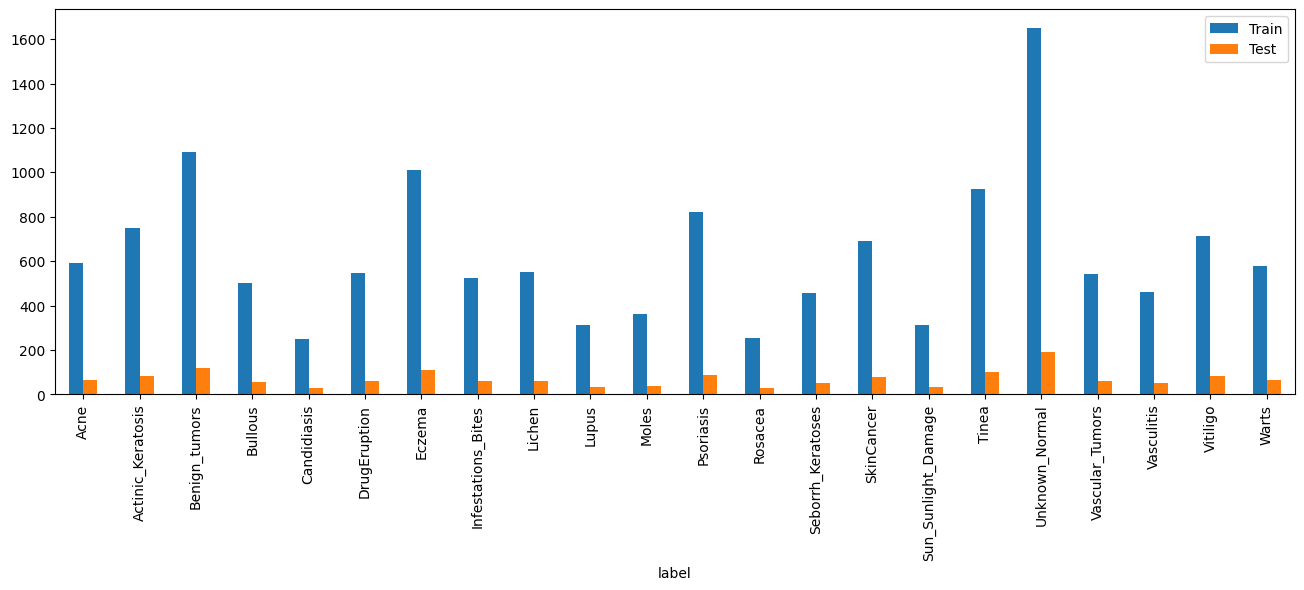

In [19]:
df_split.plot(kind="bar", figsize=(16,5))

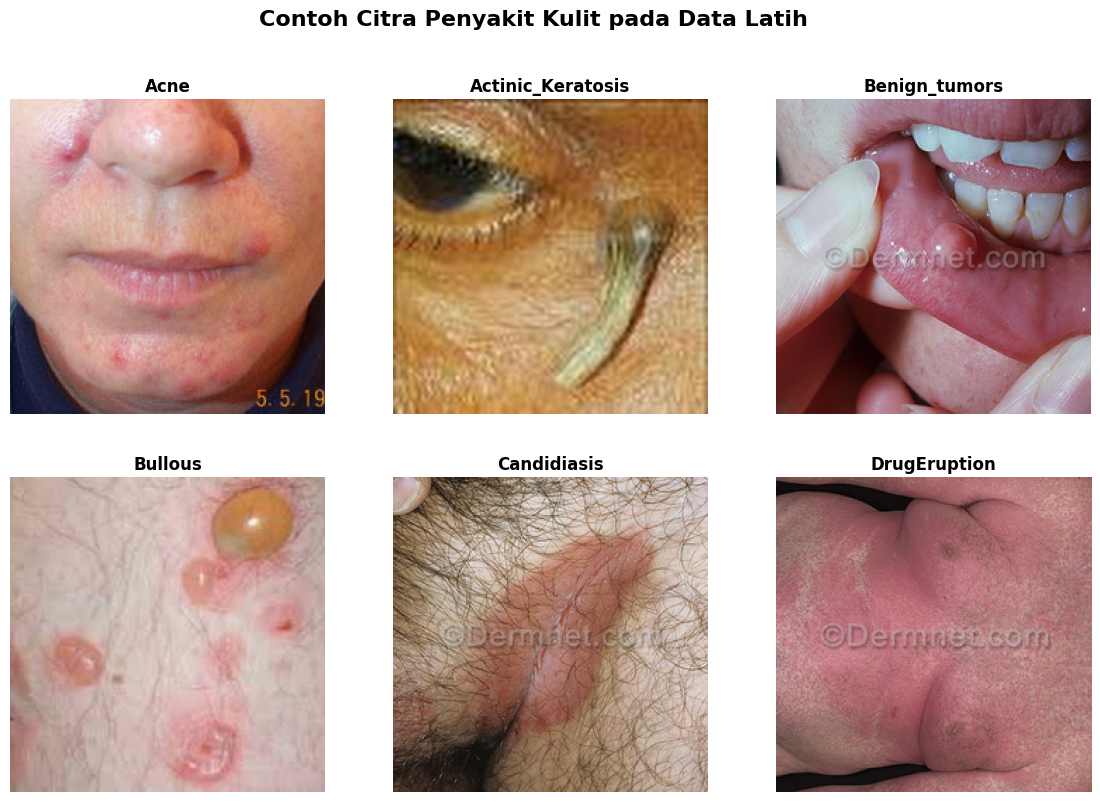

In [20]:
# Visualisasi Contoh Citra Penyakit Kulit
plt.figure(figsize=(14, 9))

num_samples = 6
rows, cols = 2, 3
target_size = (224, 224)

for idx, label in enumerate(classes[:num_samples]):
    class_path = os.path.join(TRAIN_PATH, label)

    image_files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]


    img_path = os.path.join(class_path, random.choice(image_files))
    img = Image.open(img_path).convert("RGB")


    img = ImageOps.fit(
        img,
        target_size,
        method=Image.Resampling.LANCZOS,
        centering=(0.5, 0.5)
    )

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize=12, fontweight="bold")
    plt.axis("off")

plt.suptitle(
    "Contoh Citra Penyakit Kulit pada Data Latih",
    fontsize=16,
    fontweight="bold"
)

plt.show()

In [21]:
# Analisis Ukuran Citra
def get_size(img_path):
    with Image.open(img_path) as img:
        return img.size

image_paths = []

for label in classes:
    class_path = os.path.join(TRAIN_PATH, label)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_path, img_name))

with ThreadPoolExecutor() as executor:
    sizes = list(executor.map(get_size, image_paths))

sizes_df = pd.DataFrame(sizes, columns=["Width", "Height"])
sizes_df.describe()

Width        Height
count  13898.000000  13898.000000
mean     657.280616    554.076989
std      392.382285    429.205255
min      100.000000     93.000000
25%      472.000000    464.000000
50%      720.000000    474.000000
75%      720.000000    656.750000
max     8688.000000   8192.000000

## preprocessing data

In [22]:
# Data Preprocessing dan Penyimpanan Citra yang Telah Diubah Ukuran
BASE_PATH = r"Data\SkinDisease\SkinDisease"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH  = os.path.join(BASE_PATH, "test")

OUTPUT_BASE = r"Data\data preprocessing"
OUTPUT_TRAIN = os.path.join(OUTPUT_BASE, "train")
OUTPUT_VAL   = os.path.join(OUTPUT_BASE, "val")
OUTPUT_TEST  = os.path.join(OUTPUT_BASE, "test")

os.makedirs(OUTPUT_TRAIN, exist_ok=True)
os.makedirs(OUTPUT_VAL, exist_ok=True)
os.makedirs(OUTPUT_TEST, exist_ok=True)

In [23]:
# Parameters
IMAGE_SIZE = 224
VAL_SPLIT = 0.10
SEED = 42
random.seed(SEED)


# Transformasi Citra
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

In [24]:
# Fungsi Preprocessing dan Penyimpanan Citra
def preprocess_and_save(image_paths, input_class_path, output_class_path, transform):
    os.makedirs(output_class_path, exist_ok=True)

    for img_name in tqdm(image_paths, leave=False):
        img_path = os.path.join(input_class_path, img_name)

        try:
            img = Image.open(img_path).convert("RGB")
            img = transform(img)

            save_name = os.path.splitext(img_name)[0] + ".png"
            img.save(os.path.join(output_class_path, save_name))

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [25]:
# Preprocessing dan Penyimpanan Data Train dan Val
print("Preprocessing TRAIN dan VAL data...")

classes = sorted(os.listdir(TRAIN_PATH))

for label in classes:
    input_class_path = os.path.join(TRAIN_PATH, label)

    images = [
        f for f in os.listdir(input_class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    random.shuffle(images)

    val_size = int(len(images) * VAL_SPLIT)
    val_images = images[:val_size]
    train_images = images[val_size:]

    preprocess_and_save(
        train_images,
        input_class_path,
        os.path.join(OUTPUT_TRAIN, label),
        train_transform
    )

    preprocess_and_save(
        val_images,
        input_class_path,
        os.path.join(OUTPUT_VAL, label),
        val_test_transform
    )

Preprocessing TRAIN dan VAL data...


In [26]:
# Preprocessing dan Penyimpanan Data Test
print("Preprocessing TEST data...")

classes_test = sorted(os.listdir(TEST_PATH))

for label in classes_test:
    input_class_path = os.path.join(TEST_PATH, label)

    images = [
        f for f in os.listdir(input_class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    preprocess_and_save(
        images,
        input_class_path,
        os.path.join(OUTPUT_TEST, label),
        val_test_transform
    )

Preprocessing TEST data...


In [30]:
# Verifikasi Hasil Preprocessing
def count_images(base_path):
    total = 0
    per_class = {}

    for label in sorted(os.listdir(base_path)):
        class_path = os.path.join(base_path, label)
        if not os.path.isdir(class_path):
            continue

        images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        per_class[label] = len(images)
        total += len(images)

    return total, per_class


train_total, train_per_class = count_images(OUTPUT_TRAIN)
val_total, val_per_class     = count_images(OUTPUT_VAL)
test_total, test_per_class   = count_images(OUTPUT_TEST)

print("\nRINGKASAN DATA PREPROCESSING")
print(f"Total TRAIN : {train_total}")
print(f"Total VAL   : {val_total}")
print(f"Total TEST  : {test_total}")
print(f"TOTAL SEMUA : {train_total + val_total + test_total}")


RINGKASAN DATA PREPROCESSING
Total TRAIN : 12515
Total VAL   : 1383
Total TEST  : 1546
TOTAL SEMUA : 15444


## 1. CNN from scratch

In [39]:
# Path Configuration for Model Training
BASE_PATH = r"Data\SkinDisease\SkinDisease"
TRAIN_DIR = r"Data\data preprocessing\train"
VAL_DIR   = r"Data\data preprocessing\val"
TEST_DIR  = r"Data\data preprocessing\test"

MODEL_DIR = r"D:\Skin Disease Detection\model"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
# Model Training Parameters
# IMAGE_SIZE = 224
# BATCH_SIZE = 32
# EPOCHS = 100
# INITIAL_LR = 0.001
# WEIGHT_DECAY = 1e-4
# SCHEDULER_PATIENCE = 7
# EARLY_STOP_PATIENCE = 20


IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 200
INITIAL_LR = 0.001
WEIGHT_DECAY = 5e-4
SCHEDULER_PATIENCE = 10
EARLY_STOP_PATIENCE = 30

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Training configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Initial LR: {INITIAL_LR}")
print(f"  - Weight Decay: {WEIGHT_DECAY}")
print(f"  - Scheduler Patience: {SCHEDULER_PATIENCE} epochs")
print(f"  - Early Stop Patience: {EARLY_STOP_PATIENCE} epochs")

Device: cuda
Training configuration:
  - Epochs: 200
  - Initial LR: 0.001
  - Weight Decay: 0.0005
  - Scheduler Patience: 10 epochs
  - Early Stop Patience: 30 epochs


In [41]:
# Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [42]:
# Load Datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=VAL_DIR,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=val_test_transform)

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Jumlah kelas: {NUM_CLASSES}")
print(f"Nama kelas: {CLASS_NAMES}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Jumlah kelas: 22
Nama kelas: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


In [43]:
# Model CNN Base
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [44]:
# Inisialisasi Model
model = SimpleCNN(NUM_CLASSES).to(DEVICE)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=SCHEDULER_PATIENCE,
    min_lr=1e-6
)

In [45]:
# Training Loop
best_val_loss = float("inf")
early_stop_counter = 0
best_model_state = copy.deepcopy(model.state_dict())

history = {
    "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []
}

num_epochs_trained = 0
current_lr = INITIAL_LR

print("=" * 100)
print(f"{'STARTING TRAINING - CNN FROM SCRATCH':^100}")
print("=" * 100)
print(f"{'Epoch':<6} {'Train Loss':>12} {'Train Acc':>12} {'Val Loss':>12} {'Val Acc':>12} {'LR':>12} {'Best Val Loss':>16} {'Status':<20}")
print("-" * 100)

for epoch in range(EPOCHS):
    num_epochs_trained = epoch + 1

    # TRAINING PHASE
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:3d}/{EPOCHS} [Train]", leave=False)
    for images, labels in train_pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({"loss": f"{running_loss/total:.4f}", "acc": f"{correct/total:.4f}"})

    train_loss = running_loss / total
    train_acc = correct / total

    # VALIDATION PHASE
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1:3d}/{EPOCHS} [Valid]", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_pbar.set_postfix({"loss": f"{val_running_loss/total:.4f}", "acc": f"{correct/total:.4f}"})

    val_loss = val_running_loss / total
    val_acc = correct / total

    # Scheduler & LR update (manual verbose replacement)
    prev_lr = optimizer.param_groups[0]['lr']

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    lr_changed = current_lr != prev_lr


    # History
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    # Early Stopping
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        status = "✓ Improved (Saved)"
    else:
        early_stop_counter += 1
        status = f"No improv ({early_stop_counter}/{EARLY_STOP_PATIENCE})"

    print(f"{epoch+1:<6} {train_loss:12.4f} {train_acc:12.4f} {val_loss:12.4f} {val_acc:12.4f} {current_lr:12.0e} {best_val_loss:16.4f} {status:<20}")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print("-" * 100)
        print("EARLY STOPPING TRIGGERED!")
        break
# Summary
print("=" * 100)
print(f"{'TRAINING CNN FROM SCRATCH SELESAI':^100}")
print("=" * 100)
print(f"Best Validation Loss : {best_val_loss:.6f}")
print(f"Total epochs trained : {num_epochs_trained}")
print(f"Final Learning Rate  : {current_lr:.0e}")
print("=" * 100)

# Load best model
model.load_state_dict(best_model_state)
model.eval()

                                STARTING TRAINING - CNN FROM SCRATCH                                
Epoch    Train Loss    Train Acc     Val Loss      Val Acc           LR    Best Val Loss Status              
----------------------------------------------------------------------------------------------------


Epoch   1/200 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

1            2.8703       0.1522       2.7704       0.1772        1e-03           2.7704 ✓ Improved (Saved)  


2            2.7422       0.1860       2.6943       0.2039        1e-03           2.6943 ✓ Improved (Saved)  


3            2.6907       0.1963       2.6013       0.2104        1e-03           2.6013 ✓ Improved (Saved)  


4            2.6514       0.2063       2.5639       0.2234        1e-03           2.5639 ✓ Improved (Saved)  


5            2.6252       0.2146       2.5500       0.2480        1e-03           2.5500 ✓ Improved (Saved)  


6            2.5968       0.2180       2.5560       0.2198        1e-03           2.5500 No improv (1/30)    


7            2.5741       0.2297       2.4931       0.2495        1e-03           2.4931 ✓ Improved (Saved)  


8            2.5562       0.2347       2.4729       0.2415        1e-03           2.4729 ✓ Improved (Saved)  


9            2.5352       0.2376       2.4581       0.2610        1e-03           2.4581 ✓ Improved (Saved)  


10           2.5144       0.2469       2.4205       0.2798        1e-03           2.4205 ✓ Improved (Saved)  


11           2.4982       0.2481       2.4094       0.2661        1e-03           2.4094 ✓ Improved (Saved)  


12           2.4889       0.2505       2.3959       0.2697        1e-03           2.3959 ✓ Improved (Saved)  


13           2.4704       0.2535       2.3838       0.2784        1e-03           2.3838 ✓ Improved (Saved)  


14           2.4566       0.2584       2.3692       0.2690        1e-03           2.3692 ✓ Improved (Saved)  


15           2.4138       0.2718       2.3175       0.2936        1e-03           2.3175 ✓ Improved (Saved)  


16           2.4093       0.2711       2.3495       0.2907        1e-03           2.3175 No improv (1/30)    


17           2.3787       0.2746       2.2785       0.3066        1e-03           2.2785 ✓ Improved (Saved)  


18           2.3647       0.2783       2.3348       0.2842        1e-03           2.2785 No improv (1/30)    


19           2.3321       0.2883       2.2387       0.3030        1e-03           2.2387 ✓ Improved (Saved)  


20           2.3005       0.2965       2.2170       0.3080        1e-03           2.2170 ✓ Improved (Saved)  


21           2.2981       0.2952       2.2298       0.3102        1e-03           2.2170 No improv (1/30)    


22           2.2739       0.3024       2.2959       0.3066        1e-03           2.2170 No improv (2/30)    


23           2.2597       0.3025       2.2060       0.3210        1e-03           2.2060 ✓ Improved (Saved)  


24           2.2568       0.3061       2.1793       0.3348        1e-03           2.1793 ✓ Improved (Saved)  


25           2.2494       0.3024       2.1684       0.3189        1e-03           2.1684 ✓ Improved (Saved)  


26           2.2178       0.3192       2.1281       0.3485        1e-03           2.1281 ✓ Improved (Saved)  


27           2.2111       0.3211       2.1306       0.3283        1e-03           2.1281 No improv (1/30)    


28           2.2161       0.3197       2.1512       0.3333        1e-03           2.1281 No improv (2/30)    


29           2.2102       0.3170       2.1068       0.3391        1e-03           2.1068 ✓ Improved (Saved)  


30           2.2217       0.3160       2.1411       0.3427        1e-03           2.1068 No improv (1/30)    


31           2.1954       0.3226       2.1756       0.3420        1e-03           2.1068 No improv (2/30)    


32           2.1678       0.3245       2.1224       0.3449        1e-03           2.1068 No improv (3/30)    


33           2.1642       0.3310       2.0795       0.3644        1e-03           2.0795 ✓ Improved (Saved)  


34           2.1558       0.3306       2.0847       0.3579        1e-03           2.0795 No improv (1/30)    


35           2.1506       0.3362       2.1127       0.3586        1e-03           2.0795 No improv (2/30)    


36           2.1463       0.3326       2.1040       0.3442        1e-03           2.0795 No improv (3/30)    


37           2.1403       0.3386       2.0605       0.3601        1e-03           2.0605 ✓ Improved (Saved)  


38           2.1491       0.3344       2.1172       0.3456        1e-03           2.0605 No improv (1/30)    


39           2.1387       0.3390       2.0748       0.3557        1e-03           2.0605 No improv (2/30)    


40           2.1137       0.3441       2.0526       0.3579        1e-03           2.0526 ✓ Improved (Saved)  


41           2.1202       0.3390       2.0587       0.3623        1e-03           2.0526 No improv (1/30)    


42           2.1080       0.3412       2.0668       0.3579        1e-03           2.0526 No improv (2/30)    


43           2.1117       0.3440       2.0222       0.3644        1e-03           2.0222 ✓ Improved (Saved)  


44           2.0871       0.3481       2.0409       0.3702        1e-03           2.0222 No improv (1/30)    


45           2.1002       0.3465       2.0562       0.3680        1e-03           2.0222 No improv (2/30)    


46           2.0743       0.3588       2.0357       0.3738        1e-03           2.0222 No improv (3/30)    


47           2.0781       0.3546       2.0205       0.3644        1e-03           2.0205 ✓ Improved (Saved)  


48           2.0688       0.3608       2.0334       0.3615        1e-03           2.0205 No improv (1/30)    


49           2.0718       0.3527       2.0057       0.3601        1e-03           2.0057 ✓ Improved (Saved)  


50           2.0737       0.3541       2.0240       0.3594        1e-03           2.0057 No improv (1/30)    


51           2.0390       0.3620       1.9935       0.3839        1e-03           1.9935 ✓ Improved (Saved)  


52           2.0581       0.3607       2.0106       0.3738        1e-03           1.9935 No improv (1/30)    


53           2.0622       0.3640       2.0301       0.3717        1e-03           1.9935 No improv (2/30)    


54           2.0624       0.3661       2.0071       0.3919        1e-03           1.9935 No improv (3/30)    


55           2.0416       0.3648       2.0402       0.3637        1e-03           1.9935 No improv (4/30)    


56           2.0297       0.3686       1.9823       0.3854        1e-03           1.9823 ✓ Improved (Saved)  


57           2.0236       0.3678       2.0662       0.3673        1e-03           1.9823 No improv (1/30)    


58           2.0144       0.3748       1.9893       0.3905        1e-03           1.9823 No improv (2/30)    


59           2.0082       0.3748       1.9735       0.3933        1e-03           1.9735 ✓ Improved (Saved)  


60           2.0156       0.3728       1.9991       0.3868        1e-03           1.9735 No improv (1/30)    


61           2.0033       0.3746       1.9810       0.3955        1e-03           1.9735 No improv (2/30)    


62           1.9964       0.3783       1.9801       0.3847        1e-03           1.9735 No improv (3/30)    


63           1.9954       0.3750       1.9838       0.3839        1e-03           1.9735 No improv (4/30)    


64           1.9930       0.3765       1.9613       0.4064        1e-03           1.9613 ✓ Improved (Saved)  


65           1.9810       0.3825       1.9761       0.3854        1e-03           1.9613 No improv (1/30)    


66           1.9810       0.3805       1.9949       0.3666        1e-03           1.9613 No improv (2/30)    


67           1.9930       0.3784       1.9391       0.3919        1e-03           1.9391 ✓ Improved (Saved)  


68           1.9840       0.3815       1.9782       0.3782        1e-03           1.9391 No improv (1/30)    


69           2.0002       0.3808       1.9724       0.3933        1e-03           1.9391 No improv (2/30)    


70           1.9757       0.3825       1.9446       0.4013        1e-03           1.9391 No improv (3/30)    


71           1.9736       0.3817       1.9394       0.3977        1e-03           1.9391 No improv (4/30)    


72           1.9620       0.3918       1.9358       0.4020        1e-03           1.9358 ✓ Improved (Saved)  


73           1.9544       0.3893       1.9477       0.3933        1e-03           1.9358 No improv (1/30)    


74           1.9638       0.3865       1.9178       0.4078        1e-03           1.9178 ✓ Improved (Saved)  


75           1.9674       0.3891       1.9396       0.3970        1e-03           1.9178 No improv (1/30)    


76           1.9574       0.3821       1.9029       0.4078        1e-03           1.9029 ✓ Improved (Saved)  


77           1.9432       0.3930       1.9189       0.4107        1e-03           1.9029 No improv (1/30)    


78           1.9343       0.3935       1.9232       0.3955        1e-03           1.9029 No improv (2/30)    


79           1.9506       0.3956       1.9184       0.4049        1e-03           1.9029 No improv (3/30)    


80           1.9427       0.3918       1.9283       0.4107        1e-03           1.9029 No improv (4/30)    


81           1.9459       0.3874       1.8773       0.4223        1e-03           1.8773 ✓ Improved (Saved)  


82           1.9291       0.4000       1.9058       0.3991        1e-03           1.8773 No improv (1/30)    


83           1.9220       0.4010       1.8905       0.4273        1e-03           1.8773 No improv (2/30)    


84           1.9386       0.3962       1.9662       0.3948        1e-03           1.8773 No improv (3/30)    


85           1.9196       0.3973       1.9263       0.3984        1e-03           1.8773 No improv (4/30)    


86           1.9176       0.4009       1.9182       0.4244        1e-03           1.8773 No improv (5/30)    


87           1.9188       0.3999       1.9150       0.4179        1e-03           1.8773 No improv (6/30)    


88           1.9326       0.3950       1.9025       0.4078        1e-03           1.8773 No improv (7/30)    


89           1.9120       0.4028       1.9021       0.4208        1e-03           1.8773 No improv (8/30)    


90           1.9021       0.4038       1.9500       0.3999        1e-03           1.8773 No improv (9/30)    


91           1.9042       0.4006       1.8921       0.4150        1e-03           1.8773 No improv (10/30)   


92           1.9257       0.4022       1.8865       0.4215        5e-04           1.8773 No improv (11/30)   


93           1.8264       0.4260       1.8549       0.4375        5e-04           1.8549 ✓ Improved (Saved)  


94           1.8219       0.4255       1.8777       0.4223        5e-04           1.8549 No improv (1/30)    


95           1.8194       0.4249       1.8582       0.4360        5e-04           1.8549 No improv (2/30)    


96           1.8179       0.4288       1.8883       0.4425        5e-04           1.8549 No improv (3/30)    


97           1.8016       0.4293       1.8556       0.4418        5e-04           1.8549 No improv (4/30)    


98           1.7968       0.4352       1.8426       0.4396        5e-04           1.8426 ✓ Improved (Saved)  


99           1.7857       0.4402       1.8553       0.4382        5e-04           1.8426 No improv (1/30)    


100          1.7802       0.4414       1.8722       0.4252        5e-04           1.8426 No improv (2/30)    


101          1.7926       0.4358       1.8501       0.4324        5e-04           1.8426 No improv (3/30)    


102          1.7800       0.4420       1.8372       0.4375        5e-04           1.8372 ✓ Improved (Saved)  


103          1.7852       0.4401       1.8187       0.4483        5e-04           1.8187 ✓ Improved (Saved)  


104          1.7692       0.4420       1.8579       0.4281        5e-04           1.8187 No improv (1/30)    


105          1.7635       0.4441       1.8389       0.4454        5e-04           1.8187 No improv (2/30)    


106          1.7639       0.4414       1.8437       0.4353        5e-04           1.8187 No improv (3/30)    


107          1.7676       0.4425       1.8383       0.4418        5e-04           1.8187 No improv (4/30)    


108          1.7480       0.4484       1.8253       0.4389        5e-04           1.8187 No improv (5/30)    


109          1.7515       0.4500       1.7919       0.4563        5e-04           1.7919 ✓ Improved (Saved)  


110          1.7499       0.4519       1.8273       0.4454        5e-04           1.7919 No improv (1/30)    


111          1.7374       0.4490       1.8070       0.4519        5e-04           1.7919 No improv (2/30)    


112          1.7393       0.4511       1.8028       0.4469        5e-04           1.7919 No improv (3/30)    


113          1.7356       0.4523       1.8054       0.4469        5e-04           1.7919 No improv (4/30)    


114          1.7406       0.4513       1.8236       0.4411        5e-04           1.7919 No improv (5/30)    


115          1.7314       0.4509       1.8235       0.4440        5e-04           1.7919 No improv (6/30)    


116          1.7250       0.4502       1.7967       0.4534        5e-04           1.7919 No improv (7/30)    


117          1.7217       0.4512       1.8114       0.4469        5e-04           1.7919 No improv (8/30)    


118          1.7372       0.4459       1.8335       0.4411        5e-04           1.7919 No improv (9/30)    


119          1.7376       0.4523       1.8183       0.4375        5e-04           1.7919 No improv (10/30)   


120          1.7379       0.4533       1.8343       0.4346        3e-04           1.7919 No improv (11/30)   


121          1.6963       0.4601       1.7733       0.4548        3e-04           1.7733 ✓ Improved (Saved)  


122          1.6774       0.4633       1.7804       0.4396        3e-04           1.7733 No improv (1/30)    


123          1.6613       0.4693       1.7932       0.4526        3e-04           1.7733 No improv (2/30)    


124          1.6790       0.4650       1.7788       0.4620        3e-04           1.7733 No improv (3/30)    


125          1.6769       0.4695       1.7855       0.4613        3e-04           1.7733 No improv (4/30)    


126          1.6527       0.4753       1.7715       0.4519        3e-04           1.7715 ✓ Improved (Saved)  


127          1.6685       0.4714       1.7802       0.4649        3e-04           1.7715 No improv (1/30)    


128          1.6553       0.4743       1.7667       0.4591        3e-04           1.7667 ✓ Improved (Saved)  


129          1.6474       0.4753       1.7774       0.4584        3e-04           1.7667 No improv (1/30)    


130          1.6444       0.4831       1.7752       0.4505        3e-04           1.7667 No improv (2/30)    


131          1.6535       0.4762       1.7654       0.4642        3e-04           1.7654 ✓ Improved (Saved)  


132          1.6507       0.4795       1.7695       0.4671        3e-04           1.7654 No improv (1/30)    


133          1.6363       0.4800       1.7723       0.4483        3e-04           1.7654 No improv (2/30)    


134          1.6507       0.4731       1.7667       0.4577        3e-04           1.7654 No improv (3/30)    


135          1.6405       0.4777       1.7561       0.4613        3e-04           1.7561 ✓ Improved (Saved)  


136          1.6196       0.4853       1.7655       0.4490        3e-04           1.7561 No improv (1/30)    


137          1.6282       0.4810       1.7645       0.4628        3e-04           1.7561 No improv (2/30)    


138          1.6454       0.4742       1.7638       0.4635        3e-04           1.7561 No improv (3/30)    


139          1.6432       0.4786       1.7717       0.4497        3e-04           1.7561 No improv (4/30)    


140          1.6233       0.4811       1.7697       0.4736        3e-04           1.7561 No improv (5/30)    


141          1.6251       0.4840       1.7590       0.4657        3e-04           1.7561 No improv (6/30)    


142          1.6087       0.4915       1.7634       0.4606        3e-04           1.7561 No improv (7/30)    


143          1.6249       0.4841       1.7649       0.4678        3e-04           1.7561 No improv (8/30)    


144          1.6237       0.4808       1.7493       0.4620        3e-04           1.7493 ✓ Improved (Saved)  


145          1.6058       0.4891       1.7428       0.4649        3e-04           1.7428 ✓ Improved (Saved)  


146          1.6180       0.4855       1.7556       0.4649        3e-04           1.7428 No improv (1/30)    


147          1.6056       0.4899       1.7640       0.4729        3e-04           1.7428 No improv (2/30)    


148          1.5999       0.4911       1.7703       0.4678        3e-04           1.7428 No improv (3/30)    


149          1.6017       0.4864       1.7529       0.4678        3e-04           1.7428 No improv (4/30)    


150          1.6043       0.4876       1.7534       0.4722        3e-04           1.7428 No improv (5/30)    


151          1.5960       0.4908       1.7718       0.4620        3e-04           1.7428 No improv (6/30)    


152          1.5946       0.4933       1.7659       0.4671        3e-04           1.7428 No improv (7/30)    


153          1.5978       0.4976       1.7571       0.4635        3e-04           1.7428 No improv (8/30)    


154          1.5895       0.4951       1.7655       0.4685        3e-04           1.7428 No improv (9/30)    


155          1.5882       0.4933       1.7701       0.4678        3e-04           1.7428 No improv (10/30)   


156          1.5903       0.4929       1.7508       0.4722        1e-04           1.7428 No improv (11/30)   


157          1.5753       0.5038       1.7463       0.4751        1e-04           1.7428 No improv (12/30)   


158          1.5769       0.4988       1.7480       0.4758        1e-04           1.7428 No improv (13/30)   


159          1.5617       0.5011       1.7336       0.4816        1e-04           1.7336 ✓ Improved (Saved)  


160          1.5802       0.4921       1.7403       0.4714        1e-04           1.7336 No improv (1/30)    


161          1.5577       0.5032       1.7548       0.4707        1e-04           1.7336 No improv (2/30)    


162          1.5505       0.5052       1.7304       0.4787        1e-04           1.7304 ✓ Improved (Saved)  


163          1.5683       0.5000       1.7406       0.4743        1e-04           1.7304 No improv (1/30)    


164          1.5681       0.5019       1.7365       0.4700        1e-04           1.7304 No improv (2/30)    


165          1.5589       0.5040       1.7327       0.4693        1e-04           1.7304 No improv (3/30)    


166          1.5550       0.5068       1.7402       0.4729        1e-04           1.7304 No improv (4/30)    


167          1.5564       0.5064       1.7310       0.4837        1e-04           1.7304 No improv (5/30)    


168          1.5395       0.5115       1.7354       0.4794        1e-04           1.7304 No improv (6/30)    


169          1.5392       0.5091       1.7459       0.4772        1e-04           1.7304 No improv (7/30)    


170          1.5452       0.5042       1.7391       0.4852        1e-04           1.7304 No improv (8/30)    


171          1.5525       0.5023       1.7387       0.4772        1e-04           1.7304 No improv (9/30)    


172          1.5400       0.5095       1.7344       0.4678        1e-04           1.7304 No improv (10/30)   


173          1.5306       0.5132       1.7391       0.4881        6e-05           1.7304 No improv (11/30)   


174          1.5340       0.5126       1.7268       0.4873        6e-05           1.7268 ✓ Improved (Saved)  


175          1.5460       0.5056       1.7310       0.4765        6e-05           1.7268 No improv (1/30)    


176          1.5432       0.5065       1.7305       0.4801        6e-05           1.7268 No improv (2/30)    


177          1.5092       0.5179       1.7242       0.4808        6e-05           1.7242 ✓ Improved (Saved)  


178          1.5432       0.5105       1.7224       0.4845        6e-05           1.7224 ✓ Improved (Saved)  


179          1.5420       0.5089       1.7232       0.4794        6e-05           1.7224 No improv (1/30)    


180          1.5313       0.5142       1.7258       0.4830        6e-05           1.7224 No improv (2/30)    


181          1.5271       0.5135       1.7178       0.4801        6e-05           1.7178 ✓ Improved (Saved)  


182          1.5322       0.5109       1.7254       0.4837        6e-05           1.7178 No improv (1/30)    


183          1.5224       0.5114       1.7289       0.4794        6e-05           1.7178 No improv (2/30)    


184          1.5175       0.5168       1.7269       0.4852        6e-05           1.7178 No improv (3/30)    


185          1.5171       0.5156       1.7206       0.4837        6e-05           1.7178 No improv (4/30)    


186          1.5218       0.5067       1.7192       0.4866        6e-05           1.7178 No improv (5/30)    


187          1.5167       0.5131       1.7241       0.4801        6e-05           1.7178 No improv (6/30)    


188          1.5137       0.5191       1.7196       0.4895        6e-05           1.7178 No improv (7/30)    


189          1.5164       0.5149       1.7182       0.4866        6e-05           1.7178 No improv (8/30)    


190          1.5086       0.5141       1.7126       0.4866        6e-05           1.7126 ✓ Improved (Saved)  


191          1.5149       0.5204       1.7243       0.4801        6e-05           1.7126 No improv (1/30)    


192          1.5165       0.5151       1.7240       0.4801        6e-05           1.7126 No improv (2/30)    


193          1.5095       0.5183       1.7250       0.4801        6e-05           1.7126 No improv (3/30)    


194          1.5127       0.5166       1.7213       0.4830        6e-05           1.7126 No improv (4/30)    


195          1.5207       0.5171       1.7118       0.4910        6e-05           1.7118 ✓ Improved (Saved)  


196          1.5043       0.5168       1.7186       0.4902        6e-05           1.7118 No improv (1/30)    


197          1.5195       0.5163       1.7043       0.4888        6e-05           1.7043 ✓ Improved (Saved)  


198          1.5093       0.5159       1.7152       0.4902        6e-05           1.7043 No improv (1/30)    


199          1.5088       0.5201       1.7178       0.4910        6e-05           1.7043 No improv (2/30)    


200          1.5235       0.5099       1.7149       0.4888        6e-05           1.7043 No improv (3/30)    
                                 TRAINING CNN FROM SCRATCH SELESAI                                  
Best Validation Loss : 1.704295
Total epochs trained : 200
Final Learning Rate  : 6e-05


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [46]:
# Classification Report
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


report_dict = classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES,
    output_dict=True,
    zero_division=0
)

report: Dict[str, Any] = cast(Dict[str, Any], report_dict)

print("=== Classification Report ===\n")
print(f"{'Class':<20} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'Support':>10}")
print("-" * 62)

# Per-class metrics
for class_name in CLASS_NAMES:
    m = report[class_name]
    support = int(m['support'])
    print(f"{class_name:<20} {m['precision']:10.4f} {m['recall']:10.4f} {m['f1-score']:10.4f} {support:10d}")

# Average metrics
macro = report['macro avg']
weighted = report['weighted avg']

print("\n=== Average Metrics ===")
print(f"{'Metric':<12} {'Macro Avg':>12} {'Weighted Avg':>15}")
print("-" * 40)
print(f"{'Precision':<12} {macro['precision']:12.4f} {weighted['precision']:15.4f}")
print(f"{'Recall':<12} {macro['recall']:12.4f} {weighted['recall']:15.4f}")
print(f"{'F1-score':<12} {macro['f1-score']:12.4f} {weighted['f1-score']:15.4f}")

total_support = int(macro['support'])
print(f"{'Support':<12} {total_support:12d} {total_support:15d}")

print(f"\nOverall Accuracy: {report['accuracy']:.4f}")

=== Classification Report ===

Class                 Precision     Recall   F1-score    Support
--------------------------------------------------------------
Acne                     0.5000     0.6615     0.5695         65
Actinic_Keratosis        0.4286     0.5422     0.4787         83
Benign_tumors            0.3246     0.6116     0.4241        121
Bullous                  0.3256     0.2545     0.2857         55
Candidiasis              0.5000     0.3704     0.4255         27
DrugEruption             0.5106     0.3934     0.4444         61
Eczema                   0.4015     0.4911     0.4418        112
Infestations_Bites       0.3659     0.2500     0.2970         60
Lichen                   0.4722     0.2787     0.3505         61
Lupus                    0.3846     0.1471     0.2128         34
Moles                    0.7857     0.2750     0.4074         40
Psoriasis                0.4312     0.5341     0.4772         88
Rosacea                  0.5625     0.6429     0.6000        

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000248B3C544A0>
Traceback (most recent call last):
  File "C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


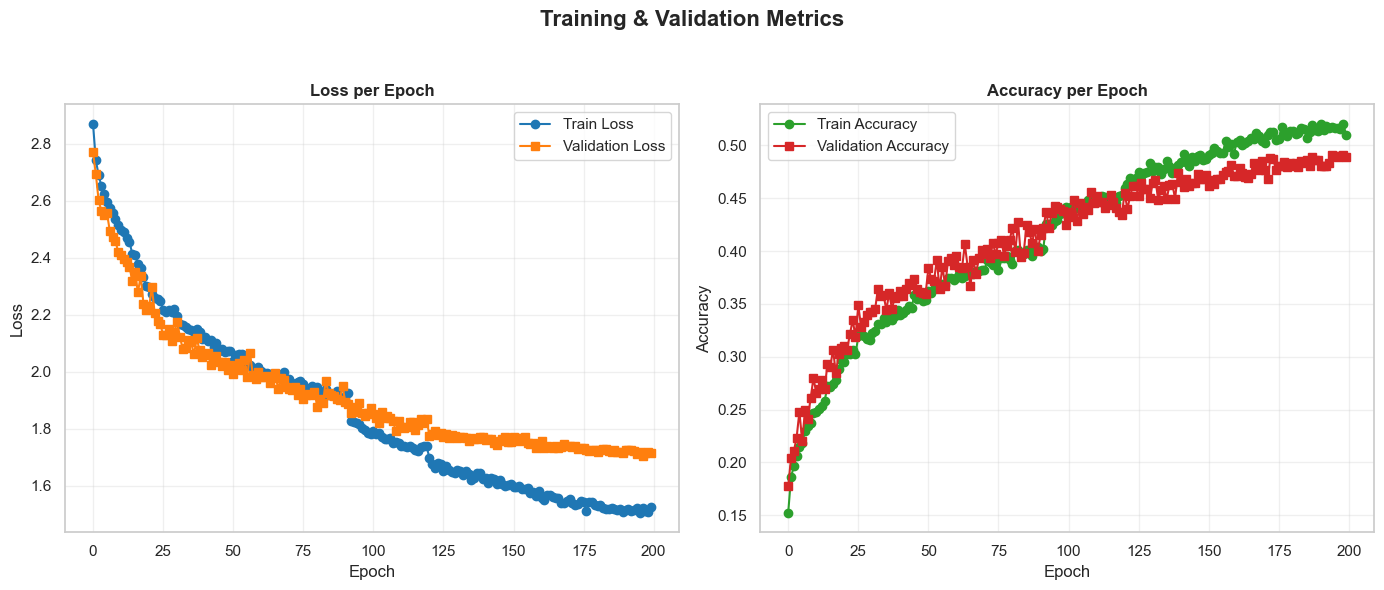

In [47]:
# Visualisasi Loss & Accuracy
sns.set(style="whitegrid")

plt.figure(figsize=(14,6))
plt.suptitle("Training & Validation Metrics", fontsize=16, weight='bold')


plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss", color='tab:blue', marker='o')
plt.plot(history["val_loss"], label="Validation Loss", color='tab:orange', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch", fontsize=12, weight='bold')
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy", color='tab:green', marker='o')
plt.plot(history["val_acc"], label="Validation Accuracy", color='tab:red', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch", fontsize=12, weight='bold')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

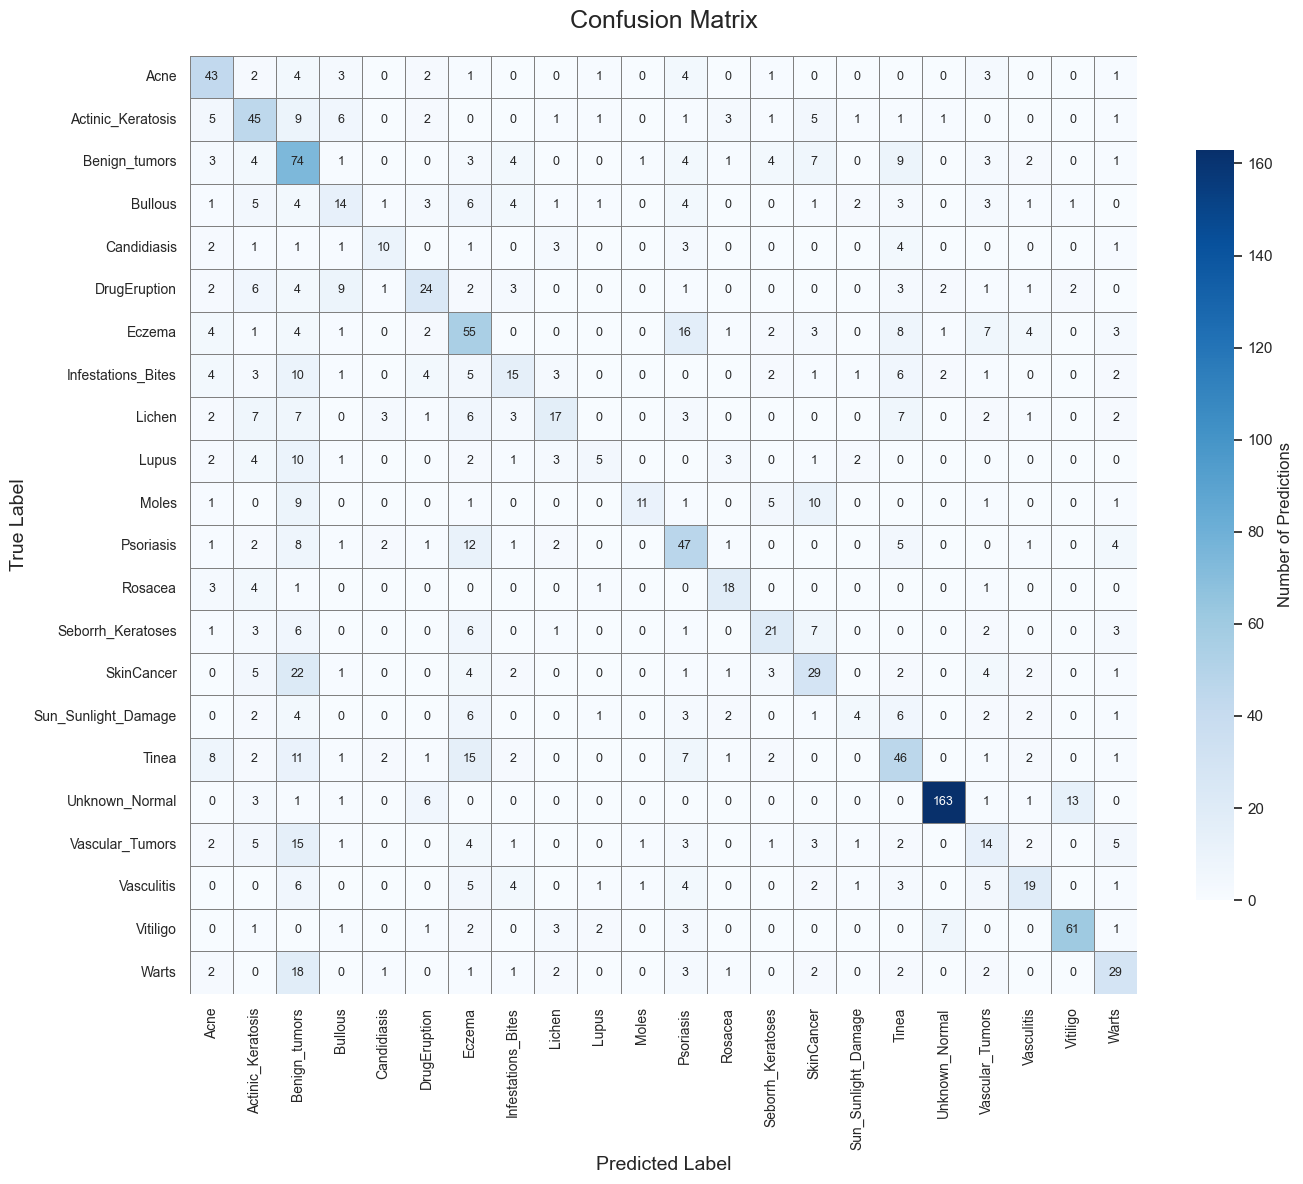

In [48]:
# Evaluasi Test Set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


report = classification_report(
    y_true, y_pred,
    target_names=CLASS_NAMES,
    output_dict=True,
    zero_division=0
)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8, "label": "Number of Predictions"},
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    annot_kws={"size": 9}
)

plt.title("Confusion Matrix", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.grid(False)

plt.tight_layout()
plt.show()

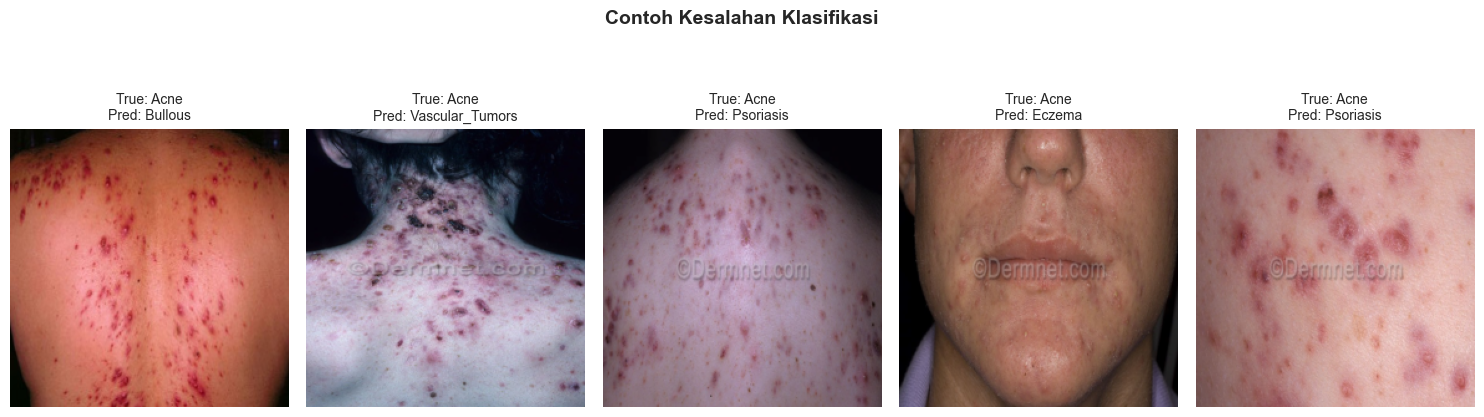

In [49]:
# Error Analysis
errors = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i].cpu() != labels[i]:
                errors.append((images[i].cpu(), labels[i].item(), preds[i].cpu().item()))
        if len(errors) >= 20:
            break

num_examples = min(5, len(errors))
if num_examples > 0:
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        img_tensor, true_label, pred_label = errors[i]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(1, num_examples, i+1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]}", fontsize=10)
    plt.suptitle("Contoh Kesalahan Klasifikasi", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()

In [50]:
# Save Model .pkl
MODEL_PATH = os.path.join(MODEL_DIR, "cnn_skin_disease.pkl")

model_package = {
    "model_state_dict": model.state_dict(),
    "history": history,
    "classification_report": report,
    "confusion_matrix": cm,
    "image_size": IMAGE_SIZE,
    "num_classes": NUM_CLASSES,
    "model_name": "ConvNeXt_Base_Pretrained",
    "class_names": CLASS_NAMES
}

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model_package, f)

print("Model dan seluruh artefak tersimpan di:")
print(MODEL_PATH)

Model dan seluruh artefak tersimpan di:
D:\Skin Disease Detection\model\cnn_skin_disease.pkl


## 2. ConvNeXt Base

In [2]:
print("Semua library berhasil di-import!")
print(f"PyTorch version     : {torch.__version__}")
print(f"CUDA available      : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU                 : {torch.cuda.get_device_name(0)}")

Semua library berhasil di-import!
PyTorch version     : 2.5.1+cu121
CUDA available      : True
GPU                 : NVIDIA GeForce RTX 2050


In [3]:
# TRAINING PARAMETERS (OPTIMIZED FOR FASTER STAGE 2)
IMAGE_SIZE           = 224
BATCH_SIZE           = 48
EPOCHS               = 10
EARLY_STOP_PATIENCE  = 8

# Learning Rates
HEAD_ONLY_LR         = 1e-3
BASE_LR              = 1e-4
HEAD_LR_MULTIPLIER   = 5
WEIGHT_DECAY         = 1e-2

# Paths
TRAIN_DIR = r"Data\data preprocessing\train"
VAL_DIR   = r"Data\data preprocessing\val"
TEST_DIR  = r"Data\data preprocessing\test"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")
print(f"Stage 2 optimized: BASE_LR={BASE_LR}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}, EARLY_STOP_PATIENCE={EARLY_STOP_PATIENCE}")


Device: cuda
Stage 2 optimized: BASE_LR=0.0001, BATCH_SIZE=48, EPOCHS=10, EARLY_STOP_PATIENCE=8


In [4]:
# DATA TRANSFORMATIONS
CONVNEXT_MEAN = [0.485, 0.456, 0.406]
CONVNEXT_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # Geometric & scale augmentation (harus sebelum ToTensor)
    transforms.Resize((IMAGE_SIZE + 32), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    
    # Color & filter augmentation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.3),
    transforms.RandomApply([transforms.RandomAutocontrast()], p=0.3),
    
    transforms.ToTensor(),
    
    # RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'), # pyright: ignore[reportArgumentType]
    
    # Normalize terakhir
    transforms.Normalize(mean=CONVNEXT_MEAN, std=CONVNEXT_STD),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=CONVNEXT_MEAN, std=CONVNEXT_STD),
])

In [5]:
# DATASET & DATALOADER
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=VAL_DIR,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=val_test_transform)

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

print(f"Jumlah kelas : {NUM_CLASSES}")
print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples  : {len(val_dataset):,}")
print(f"Test samples : {len(test_dataset):,}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True,
                          prefetch_factor=2, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True,
                          prefetch_factor=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True,
                          prefetch_factor=2)

print("\nDataLoader siap!")

Jumlah kelas : 22
Train samples: 12,515
Val samples  : 1,383
Test samples : 1,546

DataLoader siap!


In [6]:
# MODEL: CONVNEXT-BASE
class ConvNeXtFineTune(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        
        # Load pretrained ConvNeXt-Base
        weights = ConvNeXt_Base_Weights.DEFAULT
        self.backbone = convnext_base(weights=weights)
        
        # Ambil feature dimension (1024 untuk ConvNeXt-Base)
        in_features = self.backbone.classifier[-1].in_features
        
        # Custom head dengan FIX: Flatten dulu sebelum LayerNorm
        self.backbone.classifier = nn.Sequential(
            # Flatten [B, 1024, 1, 1] → [B, 1024]
            nn.Flatten(start_dim=1),
            
            nn.LayerNorm(in_features),
            
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.Dropout(p=dropout_rate * 0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Re-inisialisasi model
model = ConvNeXtFineTune(num_classes=NUM_CLASSES, dropout_rate=0.4).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model ConvNeXt-Base FIXED!")
print(f"Total params     : {total_params:,}")
print(f"Trainable params : {trainable_params:,}")
print("Error LayerNorm sudah diperbaiki dengan nn.Flatten() sebelum LayerNorm")

Model ConvNeXt-Base FIXED!
Total params     : 88,102,550
Trainable params : 88,102,550
Error LayerNorm sudah diperbaiki dengan nn.Flatten() sebelum LayerNorm


In [7]:
# STAGE 1: HEAD ONLY TRAINING
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Freeze backbone
for param in model.backbone.features.parameters():
    param.requires_grad = False
for param in model.backbone.avgpool.parameters():
    param.requires_grad = False

optimizer = optim.AdamW(model.backbone.classifier.parameters(),
                        lr=HEAD_ONLY_LR,
                        weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=4, min_lr=1e-6)

print("STAGE 1 SIAP: Hanya classifier head yang dilatih")
print(f"Head LR: {HEAD_ONLY_LR:.0e}")

STAGE 1 SIAP: Hanya classifier head yang dilatih
Head LR: 1e-03


In [8]:
# TRAINING LOOP (DUAL-STAGE)
best_val_loss = float("inf")
early_stop_counter = 0
best_model_state = copy.deepcopy(model.state_dict())

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
num_epochs_trained = 0
current_lr = optimizer.param_groups[0]['lr']
scaler = GradScaler()

# Deteksi stage
trainable_ratio = sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters())
stage = 1 if trainable_ratio < 0.1 else 2

print("=" * 130)
print(f"{'CONVNEXT-BASE FINE-TUNING STAGE ' + str(stage):^130}")
print("=" * 130)
print(f"{'Epoch':<6} {'Train Loss':>12} {'Train Acc':>12} {'Val Loss':>12} {'Val Acc':>12} {'LR':>18} {'Best Val Loss':>16} {'Status':<20}")
print("-" * 130)

max_epochs = 20 if stage == 1 else EPOCHS

for epoch in range(max_epochs):
    num_epochs_trained += 1
    model.train()
    running_loss = correct = total = 0.0

    for images, labels in tqdm(train_loader, desc=f"Stage {stage} Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = val_correct = val_total = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    status = "✓ Improved (Saved)" if val_loss < best_val_loss else f"No improv ({early_stop_counter+1}/{EARLY_STOP_PATIENCE})"
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    print(f"{epoch+1:<6} {train_loss:12.4f} {train_acc:12.4f} {val_loss:12.4f} {val_acc:12.4f} "
          f"{current_lr:18.0e} {best_val_loss:16.4f} {status:<20}")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print("EARLY STOPPING!")
        break

    if stage == 1 and val_acc >= 0.68:
        print(f"STAGE 1 SELESAI! Val Acc {val_acc:.4f} ≥ 68% → Lanjut Stage 2")
        break


model.load_state_dict(best_model_state)
model.eval()
print(f"\nStage {stage} selesai. Best Val Loss: {best_val_loss:.6f} | Best Val Acc: {max(history['val_acc']):.4f}")
if stage == 1:
    print(">> Jalankan cell Stage 2 di bawah ini sekarang! <<")

C:\Users\acer\AppData\Local\Temp\ipykernel_30868\1310573233.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


                                                CONVNEXT-BASE FINE-TUNING STAGE 1                                                 
Epoch    Train Loss    Train Acc     Val Loss      Val Acc                 LR    Best Val Loss Status              
----------------------------------------------------------------------------------------------------------------------------------


Stage 1 Epoch 1 [Train]:   0%|          | 0/260 [00:00<?, ?it/s]C:\Users\acer\AppData\Local\Temp\ipykernel_30868\1310573233.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\acer\AppData\Local\Temp\ipykernel_30868\1310573233.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


1            2.3760       0.3353       2.1230       0.4273              1e-03           2.1230 ✓ Improved (Saved)  


2            2.1861       0.4015       2.0059       0.4743              1e-03           2.0059 ✓ Improved (Saved)  


3            2.1258       0.4236       1.9587       0.4924              1e-03           1.9587 ✓ Improved (Saved)  


4            2.0772       0.4454       1.9506       0.4917              1e-03           1.9506 ✓ Improved (Saved)  


5            2.0555       0.4528       1.9356       0.4953              1e-03           1.9356 ✓ Improved (Saved)  


6            2.0241       0.4631       1.8808       0.5155              1e-03           1.8808 ✓ Improved (Saved)  


7            2.0040       0.4716       1.8797       0.5221              1e-03           1.8797 ✓ Improved (Saved)  


8            1.9805       0.4821       1.8643       0.5459              1e-03           1.8643 ✓ Improved (Saved)  


9            1.9690       0.4857       1.8887       0.5206              1e-03           1.8643 No improv (1/8)     


10           1.9528       0.4946       1.8714       0.5199              1e-03           1.8643 No improv (2/8)     


11           1.9428       0.5013       1.8462       0.5394              1e-03           1.8462 ✓ Improved (Saved)  


12           1.9301       0.5024       1.8460       0.5380              1e-03           1.8460 ✓ Improved (Saved)  


13           1.9267       0.5059       1.8359       0.5474              1e-03           1.8359 ✓ Improved (Saved)  


14           1.9069       0.5150       1.8300       0.5322              1e-03           1.8300 ✓ Improved (Saved)  


15           1.9138       0.5109       1.8069       0.5611              1e-03           1.8069 ✓ Improved (Saved)  


16           1.8945       0.5191       1.8122       0.5575              1e-03           1.8069 No improv (1/8)     


17           1.8839       0.5224       1.8077       0.5517              1e-03           1.8069 No improv (2/8)     


18           1.8838       0.5223       1.8111       0.5517              1e-03           1.8069 No improv (3/8)     


19           1.8700       0.5247       1.8137       0.5712              1e-03           1.8069 No improv (4/8)     


20           1.8663       0.5341       1.7910       0.5741              1e-03           1.7910 ✓ Improved (Saved)  

Stage 1 selesai. Best Val Loss: 1.791012 | Best Val Acc: 0.5741
>> Jalankan cell Stage 2 di bawah ini sekarang! <<


In [9]:
# TRANSISI KE STAGE 2: FULL FINE-TUNING
for param in model.backbone.parameters():
    param.requires_grad = True

# Optimizer dengan differential LR
optimizer = optim.AdamW([
    {'params': model.backbone.features.parameters(), 'lr': BASE_LR},
    {'params': model.backbone.avgpool.parameters(),  'lr': BASE_LR},
    {'params': model.backbone.classifier.parameters(), 'lr': BASE_LR * HEAD_LR_MULTIPLIER},
], weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

print("TRANSISI BERHASIL!")
print(f"Backbone unfreezed | Backbone LR: {BASE_LR:.0e} | Head LR: {BASE_LR * HEAD_LR_MULTIPLIER:.0e}")
print("Jalankan kembali TRAINING LOOP cell untuk mulai Stage 2")

TRANSISI BERHASIL!
Backbone unfreezed | Backbone LR: 1e-04 | Head LR: 5e-04
Jalankan kembali TRAINING LOOP cell untuk mulai Stage 2


In [10]:
# TRAINING LOOP (DUAL-STAGE)
best_val_loss = float("inf")
early_stop_counter = 0
best_model_state = copy.deepcopy(model.state_dict())

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
num_epochs_trained = 0
current_lr = optimizer.param_groups[0]['lr']
scaler = GradScaler()

# Deteksi stage
trainable_ratio = sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters())
stage = 1 if trainable_ratio < 0.1 else 2

print("=" * 130)
print(f"{'CONVNEXT-BASE FINE-TUNING STAGE ' + str(stage):^130}")
print("=" * 130)
print(f"{'Epoch':<6} {'Train Loss':>12} {'Train Acc':>12} {'Val Loss':>12} {'Val Acc':>12} {'LR':>18} {'Best Val Loss':>16} {'Status':<20}")
print("-" * 130)

max_epochs = 20 if stage == 1 else EPOCHS

for epoch in range(max_epochs):
    num_epochs_trained += 1
    model.train()
    running_loss = correct = total = 0.0

    for images, labels in tqdm(train_loader, desc=f"Stage {stage} Epoch {epoch+1} [Train]", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = val_correct = val_total = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    status = "✓ Improved (Saved)" if val_loss < best_val_loss else f"No improv ({early_stop_counter+1}/{EARLY_STOP_PATIENCE})"
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    print(f"{epoch+1:<6} {train_loss:12.4f} {train_acc:12.4f} {val_loss:12.4f} {val_acc:12.4f} "
          f"{current_lr:18.0e} {best_val_loss:16.4f} {status:<20}")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print("EARLY STOPPING!")
        break

    if stage == 1 and val_acc >= 0.68:
        print(f"STAGE 1 SELESAI! Val Acc {val_acc:.4f} ≥ 68% → Lanjut Stage 2")
        break


model.load_state_dict(best_model_state)
model.eval()
print(f"\nStage {stage} selesai. Best Val Loss: {best_val_loss:.6f} | Best Val Acc: {max(history['val_acc']):.4f}")
if stage == 1:
    print(">> Jalankan cell Stage 2 di bawah ini sekarang! <<")

C:\Users\acer\AppData\Local\Temp\ipykernel_30868\1310573233.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


                                                CONVNEXT-BASE FINE-TUNING STAGE 2                                                 
Epoch    Train Loss    Train Acc     Val Loss      Val Acc                 LR    Best Val Loss Status              
----------------------------------------------------------------------------------------------------------------------------------


Stage 2 Epoch 1 [Train]:   0%|          | 0/260 [00:00<?, ?it/s]C:\Users\acer\AppData\Local\Temp\ipykernel_30868\1310573233.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\acer\AppData\Local\Temp\ipykernel_30868\1310573233.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


1            1.7566       0.5683       1.6739       0.6103              1e-04           1.6739 ✓ Improved (Saved)  


2            1.6144       0.6266       1.5814       0.6414              1e-04           1.5814 ✓ Improved (Saved)  


3            1.4967       0.6716       1.4980       0.6761              1e-04           1.4980 ✓ Improved (Saved)  


4            1.4123       0.7120       1.4437       0.6913              1e-04           1.4437 ✓ Improved (Saved)  


5            1.3375       0.7421       1.4074       0.7296              1e-04           1.4074 ✓ Improved (Saved)  


6            1.2803       0.7625       1.4107       0.7260              1e-04           1.4074 No improv (1/8)     


7            1.2101       0.7926       1.3589       0.7455              1e-04           1.3589 ✓ Improved (Saved)  


8            1.1648       0.8139       1.3792       0.7354              1e-04           1.3589 No improv (1/8)     


9            1.1208       0.8308       1.3089       0.7585              1e-04           1.3089 ✓ Improved (Saved)  


10           1.0792       0.8498       1.3054       0.7549              1e-04           1.3054 ✓ Improved (Saved)  

Stage 2 selesai. Best Val Loss: 1.305352 | Best Val Acc: 0.7585


In [11]:
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
report: Dict[str, Any] = cast(Dict[str, Any], report_dict)
cm = confusion_matrix(y_true, y_pred)

# Classification Report
print("\n=== Classification Report ===")
print(f"{'Class':<25} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'Support':>10}")
print("-" * 67)
for class_name in CLASS_NAMES:
    m = report[class_name]
    support = int(m['support'])
    print(f"{class_name:<25} {m['precision']:10.4f} {m['recall']:10.4f} {m['f1-score']:10.4f} {support:10d}")

macro = report['macro avg']
weighted = report['weighted avg']
print("\n=== Average Metrics ===")
print(f"{'Metric':<12} {'Macro Avg':>12} {'Weighted Avg':>15}")
print("-" * 40)
print(f"{'Precision':<12} {macro['precision']:12.4f} {weighted['precision']:15.4f}")
print(f"{'Recall':<12} {macro['recall']:12.4f} {weighted['recall']:15.4f}")
print(f"{'F1-score':<12} {macro['f1-score']:12.4f} {weighted['f1-score']:15.4f}")
print(f"{'Support':<12} {int(macro['support']):12d} {int(weighted['support']):15d}")
print(f"\nOverall Test Accuracy: {report['accuracy']:.4f}")


=== Classification Report ===
Class                      Precision     Recall   F1-score    Support
-------------------------------------------------------------------
Acne                          0.8696     0.9231     0.8955         65
Actinic_Keratosis             0.8133     0.7349     0.7722         83
Benign_tumors                 0.7368     0.8099     0.7717        121
Bullous                       0.7407     0.7273     0.7339         55
Candidiasis                   0.6923     0.6667     0.6792         27
DrugEruption                  0.7119     0.6885     0.7000         61
Eczema                        0.7177     0.7946     0.7542        112
Infestations_Bites            0.6308     0.6833     0.6560         60
Lichen                        0.6613     0.6721     0.6667         61
Lupus                         0.8125     0.3824     0.5200         34
Moles                         0.6829     0.7000     0.6914         40
Psoriasis                     0.8333     0.7386     0.7831   

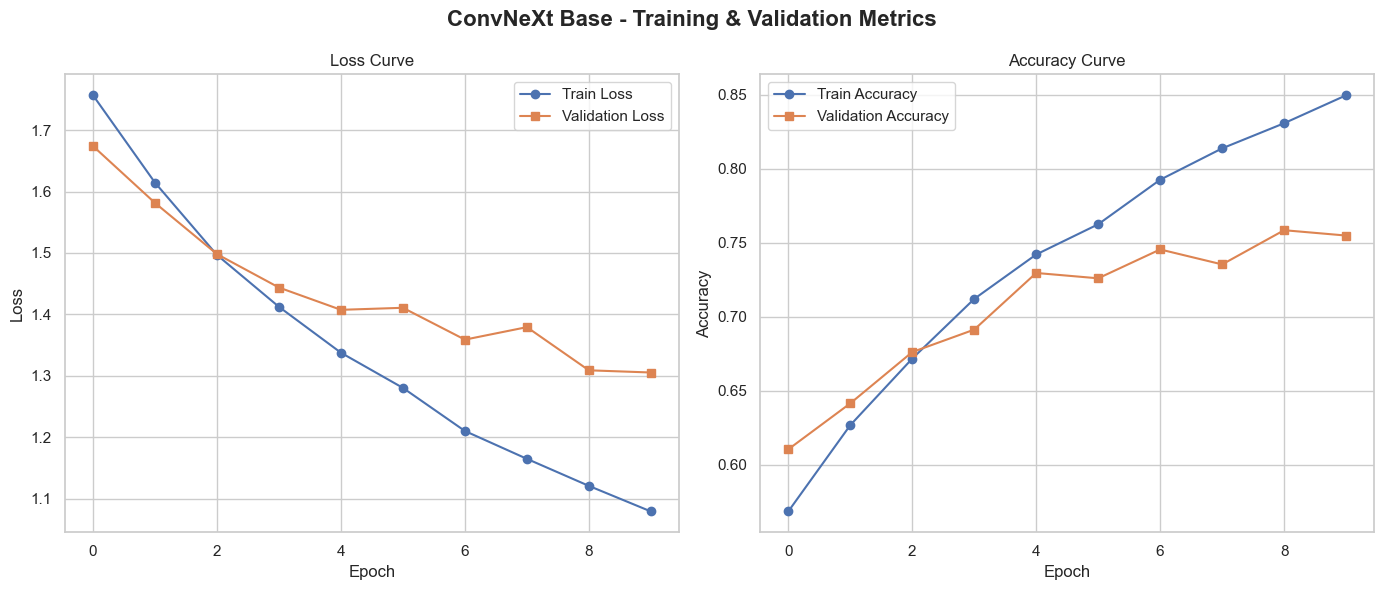

In [12]:
# Learning Curves
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.suptitle("ConvNeXt Base - Training & Validation Metrics", fontsize=16, weight='bold')
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

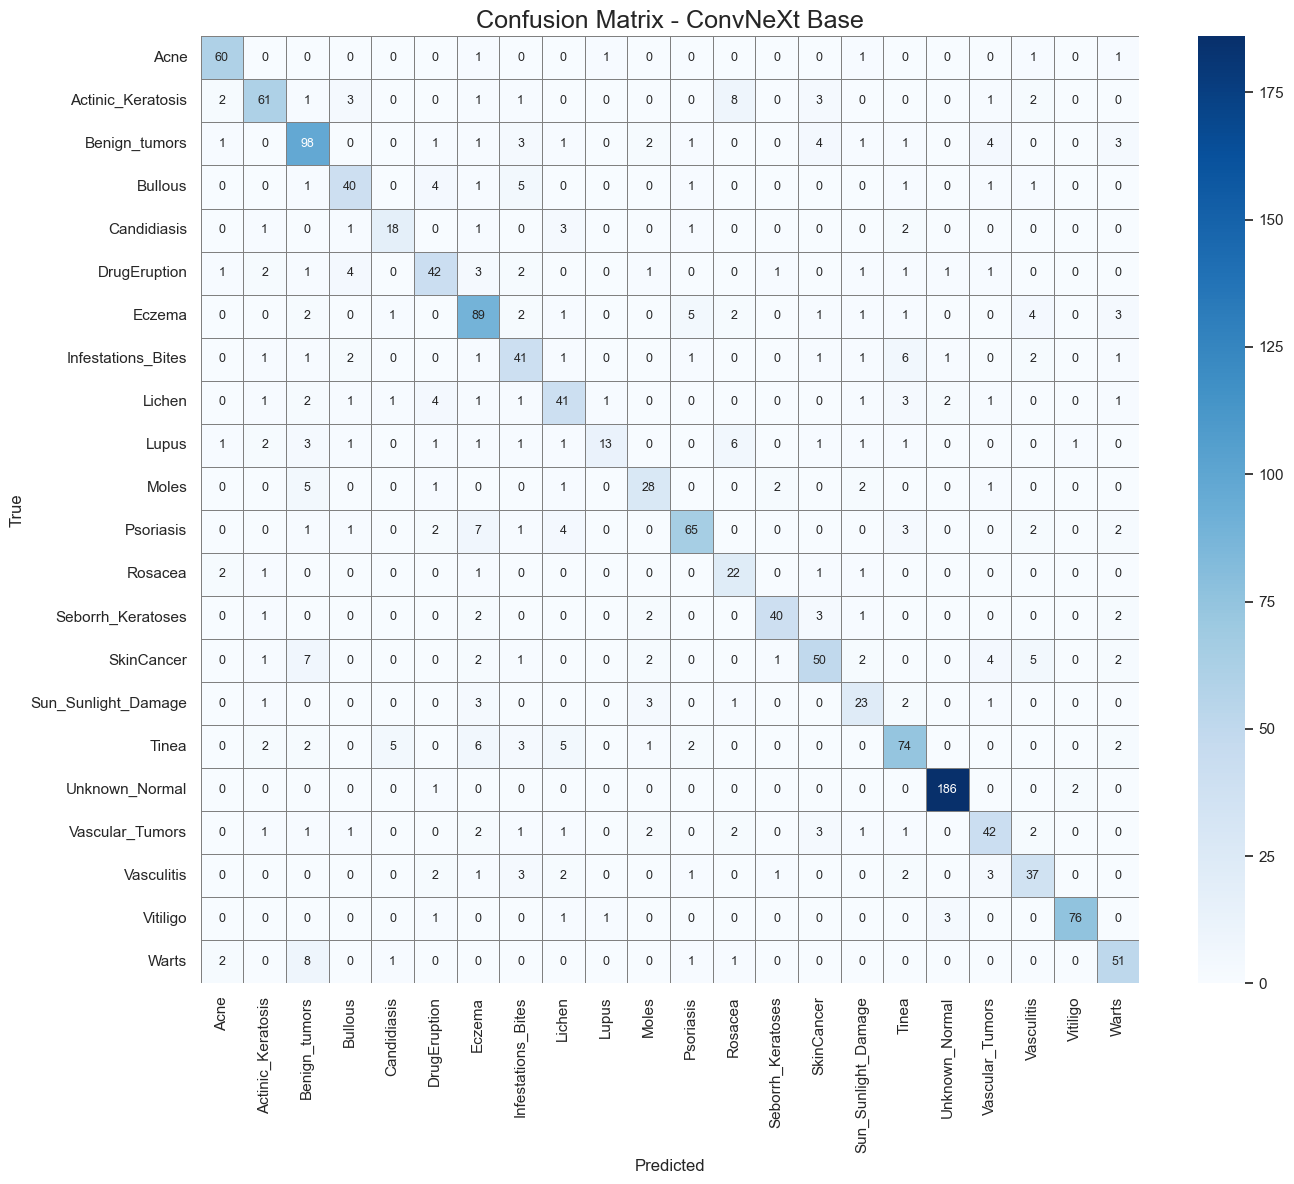

In [13]:
# Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot_kws={"size": 9})
plt.title("Confusion Matrix - ConvNeXt Base", fontsize=18)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

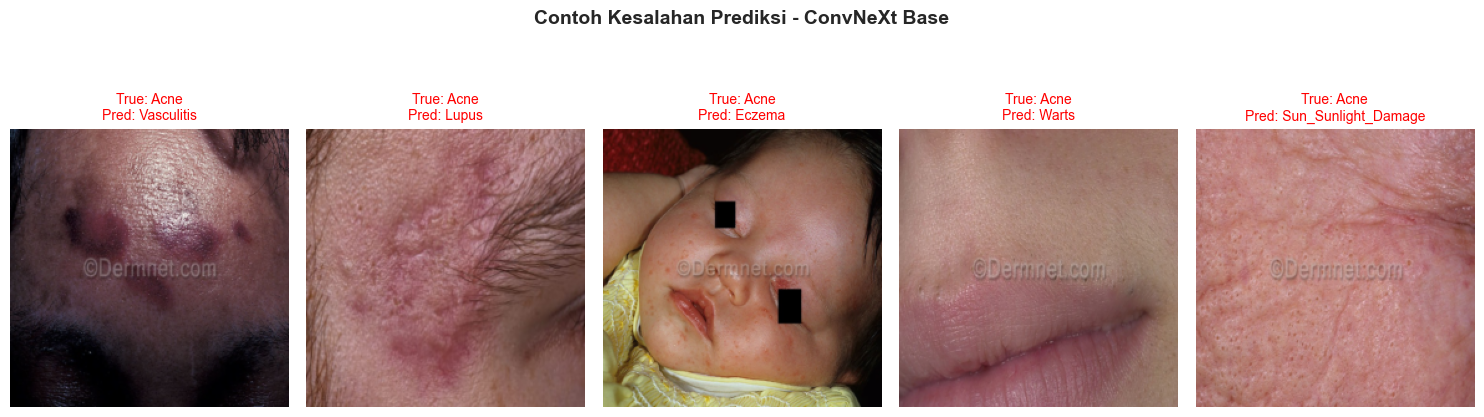

In [14]:
# Error Analysis
errors = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        mask = preds.cpu() != labels
        if mask.any():
            wrong_images = images[mask].cpu()
            wrong_true = labels[mask].cpu().numpy()
            wrong_pred = preds[mask].cpu().numpy()
            for i in range(len(wrong_true)):
                errors.append((wrong_images[i], wrong_true[i], wrong_pred[i]))
        if len(errors) >= 20:
            break

num_examples = min(5, len(errors))
if num_examples > 0:
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        img_tensor, true_label, pred_label = errors[i]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(1, num_examples, i+1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]}", fontsize=10, color="red")
    plt.suptitle("Contoh Kesalahan Prediksi - ConvNeXt Base", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()

In [ ]:
# Simpan Model
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "convnext_base_skin_disease.pkl")

model_package = {
    "model_state_dict": model.state_dict(),
    "history": history,
    "classification_report": report,
    "confusion_matrix": cm,
    "image_size": IMAGE_SIZE,
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "model_name": "ConvNeXt_Base_Pretrained_FineTuned"
}

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model_package, f)

print(f"\nModel ConvNeXt Base terbaik telah disimpan di:\n{MODEL_PATH}")


Model ConvNeXt Base terbaik telah disimpan di:
model\convnext_base_skin_disease_best.pkl


## 3. Resnet101

In [37]:
# Model Training Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
BASE_LR = 1e-4
HEAD_LR = 1e-3
WEIGHT_DECAY = 1e-4
SCHEDULER_PATIENCE = 5
EARLY_STOP_PATIENCE = 10


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


In [38]:
# Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [39]:
# Load Datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=VAL_DIR,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=val_test_transform)

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Jumlah kelas: {NUM_CLASSES}")
print(f"Nama kelas: {CLASS_NAMES}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Jumlah kelas: 22
Nama kelas: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


In [40]:
# Model: ResNet-101 Pretrained
class ResNet101FineTune(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        
        # Load pretrained ResNet-101
        weights = ResNet101_Weights.IMAGENET1K_V2
        self.backbone = resnet101(weights=weights)
        
        # Freeze semua layer dulu
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze layer3 dan layer4 untuk fine-tuning lebih optimal
        for param in self.backbone.layer3.parameters():
            param.requires_grad = True
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        
        # Ambil jumlah feature dari fc asli (2048 untuk ResNet-101)
        self.in_features = self.backbone.fc.in_features
        
        # Buat custom classifier head TERPISAH (ini yang paling aman)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate * 0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # Forward sampai sebelum fc layer (backbone output feature vector)
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Lewati fc asli, langsung ke custom classifier
        x = self.classifier(x)
        
        return x

# Inisialisasi model
NUM_CLASSES = len(train_dataset.classes)
model = ResNet101FineTune(num_classes=NUM_CLASSES, dropout_rate=0.5).to(DEVICE)

# Cek parameter trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} "
      f"({trainable_params/total_params*100:.2f}%)")

Trainable parameters: 42,115,606 / 45,609,534 (92.34%)


In [ ]:
# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Hyperparameters
BASE_LR         = 1e-4
HEAD_LR         = 5e-4
WEIGHT_DECAY    = 1e-4
SCHEDULER_PATIENCE = 5

# Differential Learning Rates
optimizer = optim.AdamW([
    # Layer awal: lr sangat kecil
    {'params': model.backbone.layer1.parameters(), 'lr': BASE_LR * 0.1},
    {'params': model.backbone.layer2.parameters(), 'lr': BASE_LR * 0.5},
    
    # Layer tengah-atas: lr sedang (utama fine-tuning)
    {'params': model.backbone.layer3.parameters(), 'lr': BASE_LR},
    {'params': model.backbone.layer4.parameters(), 'lr': BASE_LR * 5},
    
    # Custom classifier head: lr tertinggi karena dari "nol"
    {'params': model.classifier.parameters(),       'lr': HEAD_LR},
], weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=SCHEDULER_PATIENCE,
    min_lr=1e-6,
)

In [42]:
# Training Loop
best_val_loss = float("inf")
early_stop_counter = 0
best_model_state = copy.deepcopy(model.state_dict())

history = {
    "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []
}

num_epochs_trained = 0
current_lr = HEAD_LR

print("=" * 100)
print(f"{'STARTING FINE-TUNING RESNET-101':^100}")
print("=" * 100)
print(f"{'Epoch':<6} {'Train Loss':>12} {'Train Acc':>12} {'Val Loss':>12} {'Val Acc':>12} {'LR':>12} {'Best Val Loss':>16} {'Status':<20}")
print("-" * 100)

for epoch in range(EPOCHS):
    num_epochs_trained = epoch + 1

    # TRAINING
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}/{EPOCHS} [Train]", leave=False)
    for images, labels in train_pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({"loss": f"{running_loss/total:.4f}", "acc": f"{correct/total:.4f}"})

    train_loss = running_loss / total
    train_acc = correct / total

    # VALIDATION
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1:2d}/{EPOCHS} [Valid]", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_pbar.set_postfix({"loss": f"{val_running_loss/total:.4f}", "acc": f"{correct/total:.4f}"})

    val_loss = val_running_loss / total
    val_acc = correct / total

    # Scheduler & LR
    prev_lr = optimizer.param_groups[0]['lr']

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    lr_changed = current_lr != prev_lr

    # History
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    # Early Stopping
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        status = "✓ Improved (Saved)"
    else:
        early_stop_counter += 1
        status = f"No improv ({early_stop_counter}/{EARLY_STOP_PATIENCE})"

    print(f"{epoch+1:<6} {train_loss:12.4f} {train_acc:12.4f} {val_loss:12.4f} {val_acc:12.4f} {current_lr:12.0e} {best_val_loss:16.4f} {status:<20}")

    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print("-" * 100)
        print("EARLY STOPPING TRIGGERED!")
        break


print("=" * 100)
print(f"{'FINE-TUNING RESNET-101 SELESAI':^100}")
print("=" * 100)
print(f"Best Validation Loss : {best_val_loss:.6f}")
print(f"Total epochs trained : {num_epochs_trained}")
print(f"Final Learning Rate  : {current_lr:.0e}")
print("=" * 100)

model.load_state_dict(best_model_state)
model.eval()

                                  STARTING FINE-TUNING RESNET-101                                   
Epoch    Train Loss    Train Acc     Val Loss      Val Acc           LR    Best Val Loss Status              
----------------------------------------------------------------------------------------------------


1            2.2159       0.4014       1.8673       0.5315        1e-05           1.8673 ✓ Improved (Saved)  


2            1.7822       0.5720       1.7086       0.5864        1e-05           1.7086 ✓ Improved (Saved)  


3            1.5687       0.6430       1.5334       0.6544        1e-05           1.5334 ✓ Improved (Saved)  


4            1.4390       0.6954       1.4889       0.6833        1e-05           1.4889 ✓ Improved (Saved)  


5            1.3249       0.7362       1.4650       0.6941        1e-05           1.4650 ✓ Improved (Saved)  


6            1.2333       0.7775       1.4110       0.7108        1e-05           1.4110 ✓ Improved (Saved)  


7            1.1742       0.7958       1.3719       0.7260        1e-05           1.3719 ✓ Improved (Saved)  


8            1.1070       0.8268       1.4024       0.7180        1e-05           1.3719 No improv (1/10)    


9            1.0389       0.8557       1.3825       0.7310        1e-05           1.3719 No improv (2/10)    


10           0.9921       0.8708       1.3478       0.7426        1e-05           1.3478 ✓ Improved (Saved)  


11           0.9732       0.8769       1.4014       0.7390        1e-05           1.3478 No improv (1/10)    


12           0.9402       0.8928       1.3452       0.7599        1e-05           1.3452 ✓ Improved (Saved)  


13           0.9143       0.9040       1.3555       0.7607        1e-05           1.3452 No improv (1/10)    


14           0.8920       0.9109       1.3559       0.7448        1e-05           1.3452 No improv (2/10)    


15           0.8655       0.9202       1.3769       0.7542        1e-05           1.3452 No improv (3/10)    


16           0.8522       0.9267       1.3378       0.7570        1e-05           1.3378 ✓ Improved (Saved)  


17           0.8354       0.9328       1.3677       0.7614        1e-05           1.3378 No improv (1/10)    


18           0.8223       0.9364       1.3312       0.7614        1e-05           1.3312 ✓ Improved (Saved)  


19           0.8099       0.9413       1.3356       0.7563        1e-05           1.3312 No improv (1/10)    


20           0.8153       0.9380       1.3571       0.7549        1e-05           1.3312 No improv (2/10)    


21           0.7937       0.9460       1.3862       0.7397        1e-05           1.3312 No improv (3/10)    


22           0.7979       0.9459       1.3699       0.7534        1e-05           1.3312 No improv (4/10)    


23           0.7810       0.9497       1.3602       0.7549        1e-05           1.3312 No improv (5/10)    


24           0.7837       0.9496       1.3698       0.7607        5e-06           1.3312 No improv (6/10)    


25           0.7236       0.9697       1.3106       0.7708        5e-06           1.3106 ✓ Improved (Saved)  


26           0.7010       0.9787       1.3038       0.7824        5e-06           1.3038 ✓ Improved (Saved)  


27           0.6940       0.9803       1.2821       0.7708        5e-06           1.2821 ✓ Improved (Saved)  


28           0.6870       0.9831       1.2950       0.7773        5e-06           1.2821 No improv (1/10)    


29           0.6912       0.9794       1.3112       0.7701        5e-06           1.2821 No improv (2/10)    


30           0.6868       0.9810       1.3051       0.7780        5e-06           1.2821 No improv (3/10)    


31           0.6851       0.9811       1.3165       0.7672        5e-06           1.2821 No improv (4/10)    


32           0.6844       0.9832       1.3273       0.7722        5e-06           1.2821 No improv (5/10)    


33           0.6814       0.9820       1.3211       0.7751        3e-06           1.2821 No improv (6/10)    


34           0.6703       0.9867       1.2869       0.7780        3e-06           1.2821 No improv (7/10)    


35           0.6625       0.9887       1.2721       0.7852        3e-06           1.2721 ✓ Improved (Saved)  


36           0.6592       0.9900       1.3051       0.7795        3e-06           1.2721 No improv (1/10)    


37           0.6539       0.9913       1.3217       0.7744        3e-06           1.2721 No improv (2/10)    


38           0.6519       0.9929       1.3200       0.7773        3e-06           1.2721 No improv (3/10)    


39           0.6512       0.9919       1.3119       0.7852        3e-06           1.2721 No improv (4/10)    


40           0.6529       0.9920       1.3200       0.7701        3e-06           1.2721 No improv (5/10)    


41           0.6474       0.9928       1.3355       0.7787        1e-06           1.2721 No improv (6/10)    


42           0.6447       0.9933       1.3253       0.7780        1e-06           1.2721 No improv (7/10)    


43           0.6404       0.9951       1.3160       0.7881        1e-06           1.2721 No improv (8/10)    


44           0.6435       0.9935       1.3221       0.7845        1e-06           1.2721 No improv (9/10)    


45           0.6387       0.9950       1.3017       0.7896        1e-06           1.2721 No improv (10/10)   
----------------------------------------------------------------------------------------------------
EARLY STOPPING TRIGGERED!
                                   FINE-TUNING RESNET-101 SELESAI                                   
Best Validation Loss : 1.272098
Total epochs trained : 45
Final Learning Rate  : 1e-06


ResNet101FineTune(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [43]:
# Evaluasi Test & Visualisasi
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
report: Dict[str, Any] = cast(Dict[str, Any], report_dict)
cm = confusion_matrix(y_true, y_pred)

# Classification Report
print("\n=== Classification Report (ResNet-101) ===")
print(f"{'Class':<25} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'Support':>10}")
print("-" * 67)
for class_name in CLASS_NAMES:
    m = report[class_name]
    support = int(m['support'])
    print(f"{class_name:<25} {m['precision']:10.4f} {m['recall']:10.4f} {m['f1-score']:10.4f} {support:10d}")

macro = report['macro avg']
weighted = report['weighted avg']
print("\n=== Average Metrics ===")
print(f"{'Metric':<12} {'Macro Avg':>12} {'Weighted Avg':>15}")
print("-" * 40)
print(f"{'Precision':<12} {macro['precision']:12.4f} {weighted['precision']:15.4f}")
print(f"{'Recall':<12} {macro['recall']:12.4f} {weighted['recall']:15.4f}")
print(f"{'F1-score':<12} {macro['f1-score']:12.4f} {weighted['f1-score']:15.4f}")
print(f"{'Support':<12} {int(macro['support']):12d} {int(weighted['support']):15d}")
print(f"\nOverall Test Accuracy: {report['accuracy']:.4f}")


=== Classification Report (ResNet-101) ===
Class                      Precision     Recall   F1-score    Support
-------------------------------------------------------------------
Acne                          0.8630     0.9692     0.9130         65
Actinic_Keratosis             0.7791     0.8072     0.7929         83
Benign_tumors                 0.6889     0.7686     0.7266        121
Bullous                       0.7708     0.6727     0.7184         55
Candidiasis                   0.6364     0.7778     0.7000         27
DrugEruption                  0.7797     0.7541     0.7667         61
Eczema                        0.7652     0.7857     0.7753        112
Infestations_Bites            0.7200     0.6000     0.6545         60
Lichen                        0.7600     0.6230     0.6847         61
Lupus                         0.8182     0.5294     0.6429         34
Moles                         0.6923     0.6750     0.6835         40
Psoriasis                     0.8161     0.8068 

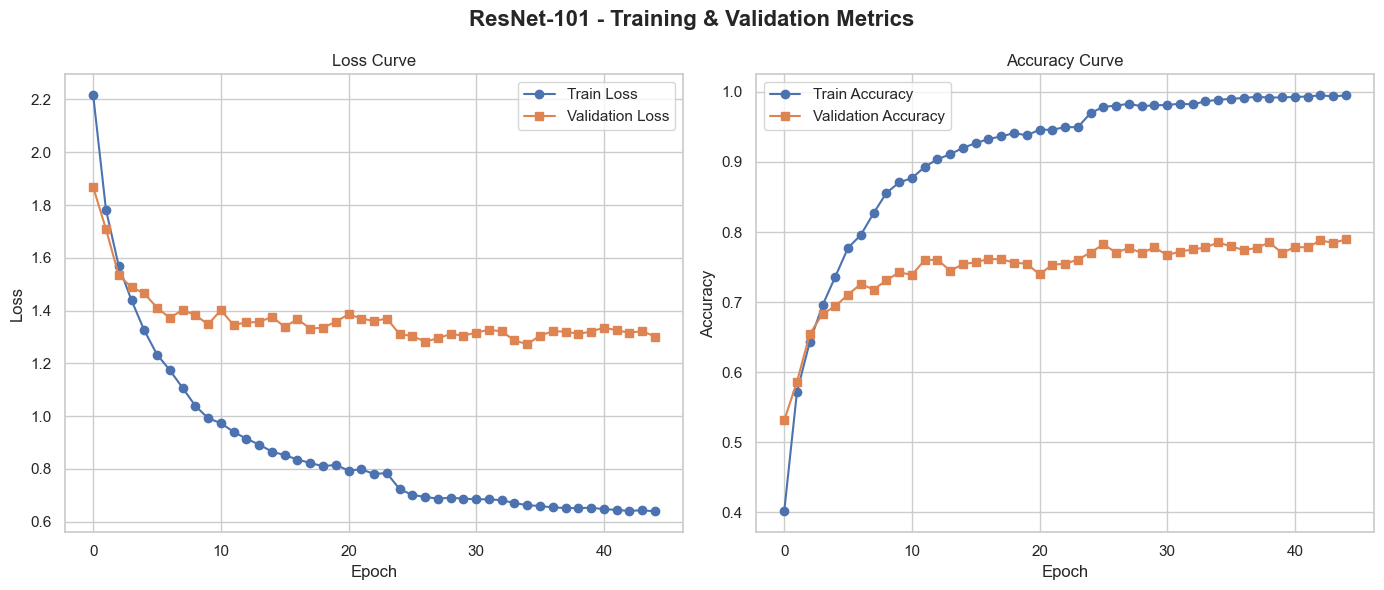

In [44]:
# Learning Curves
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.suptitle("ResNet-101 - Training & Validation Metrics", fontsize=16, weight='bold')
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

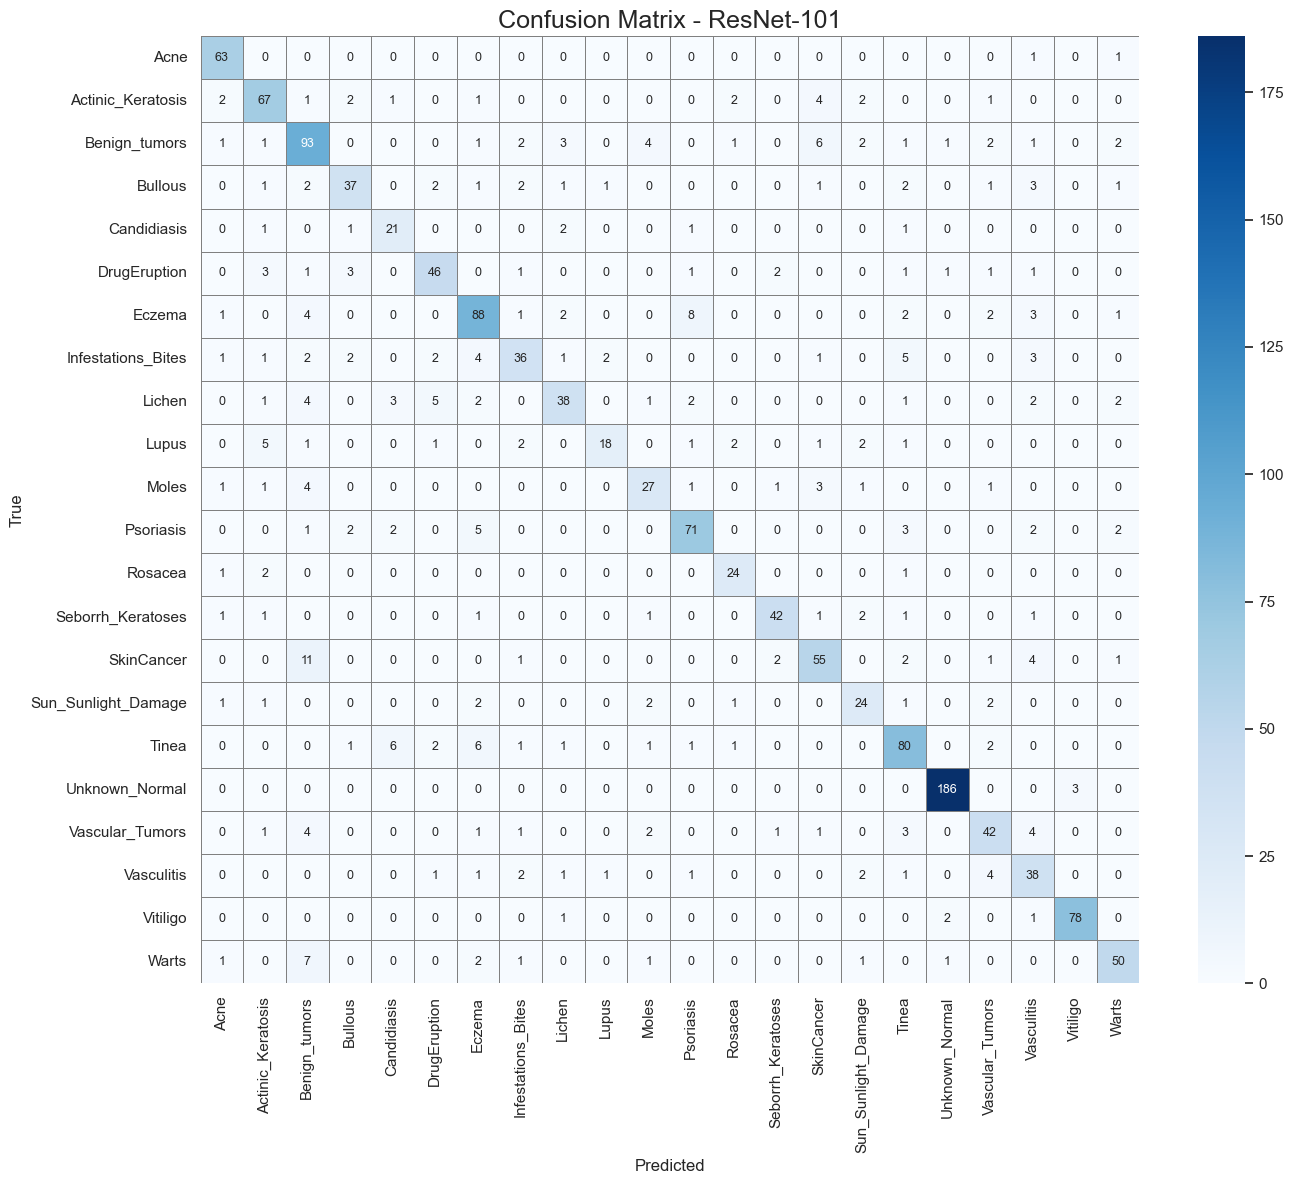

In [45]:
# Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot_kws={"size": 9})
plt.title("Confusion Matrix - ResNet-101", fontsize=18)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

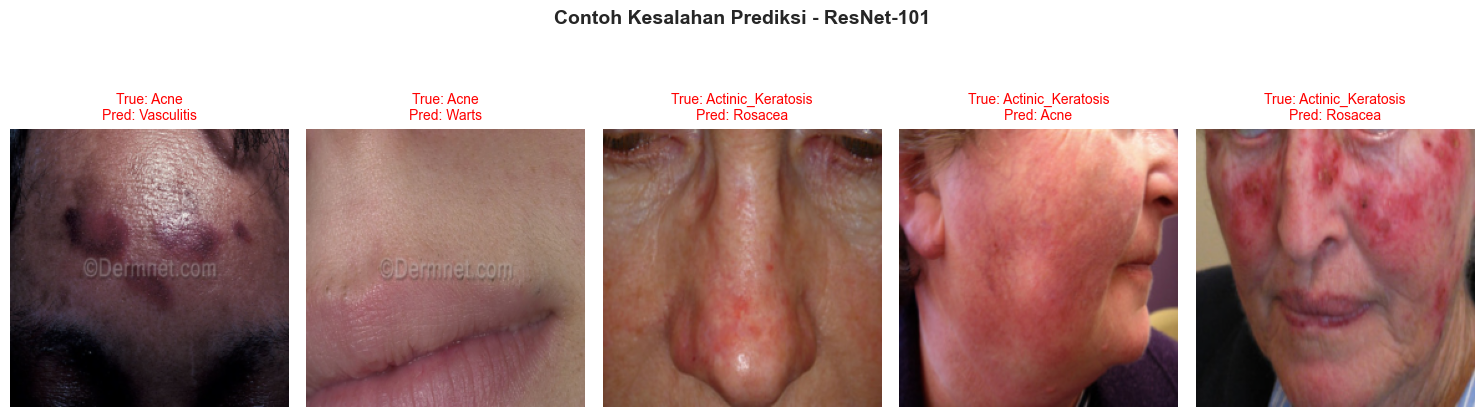

In [46]:
# Error Analysis
errors = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        mask = preds.cpu() != labels
        if mask.any():
            wrong_images = images[mask].cpu()
            wrong_true = labels[mask].cpu().numpy()
            wrong_pred = preds[mask].cpu().numpy()
            for i in range(len(wrong_true)):
                errors.append((wrong_images[i], wrong_true[i], wrong_pred[i]))
        if len(errors) >= 20:
            break

num_examples = min(5, len(errors))
if num_examples > 0:
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        img_tensor, true_label, pred_label = errors[i]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(1, num_examples, i+1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]}", fontsize=10, color="red")
    plt.suptitle("Contoh Kesalahan Prediksi - ResNet-101", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()

In [ ]:
# Simpan Model
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "resnet101_skin_disease.pkl")

model_package = {
    "model_state_dict": model.state_dict(),
    "history": history,
    "classification_report": report,
    "confusion_matrix": cm,
    "image_size": IMAGE_SIZE,
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "model_name": "ResNet101_Pretrained_FineTuned"
}

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model_package, f)

print(f"\nModel ResNet-101 terbaik telah disimpan di:\n{MODEL_PATH}")


Model ResNet-101 terbaik telah disimpan di:
model\resnet101_skin_disease_best.pkl
